In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on

%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-09-03 08:17:26.456218: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 08:17:26.487477: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 08:17:26.488561: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 08:17:27.765625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
'''
q2_regions_ele = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.052), (12.052, 14.349), (14.349, 18.993)]

q2_regions_mu = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.859), (12.859, 14.349), (14.349, 18.993)]

q2_regions_name = [r"q2reg_1", r"q2reg_2", r"q2reg_ J/$\Psi$", r"q2reg_3", r"q2reg_$\Psi(2S)$", r"q2reg_4"]

'''

'\nq2_regions_ele = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.052), (12.052, 14.349), (14.349, 18.993)]\n\nq2_regions_mu = [(0.1, 4.0), (4.0, 8.0), (8.0, 10.087), (10.087, 12.859), (12.859, 14.349), (14.349, 18.993)]\n\nq2_regions_name = [r"q2reg_1", r"q2reg_2", r"q2reg_ J/$\\Psi$", r"q2reg_3", r"q2reg_$\\Psi(2S)$", r"q2reg_4"]\n\n'

In [3]:
# List to store the signal yields and their errors from each iteration
events_and_errors_200 = []
events_and_errors_150 = []
events_and_errors_100 = []
events_and_errors_75 = []
events_and_errors_50 = []
events_and_errors_25 = []
events_and_errors_10 = []
events_and_errors_5 = []
events_and_errors_2 = []

def fit_and_plot_gaussian(csv_file, plot_title, q2reg, event_label):
    # Load the CSV file
    ratios_df = pd.read_csv(csv_file)

    # Extract the Signal Yield and Signal Yield Error columns
    MC_data_signal= ratios_df["MC_signal"]
    signal_yields = ratios_df["Signal_Yield"]
    signal_yield_errors = ratios_df["Signal_Yield_Error"]

    # Define the observable space for the signal yields
    obs_signal_yield = zfit.Space('Signal_Yield', limits=(min(signal_yields), max(signal_yields)))

    # Create Gaussian parameters (mean and standard deviation)
    r = round(np.random.rand(), 4)
    mu = zfit.Parameter(f'mu_{r}', np.mean(signal_yields))
    sigma = zfit.Parameter(f'sigma_{r}', np.std(signal_yields))

    # Define the Gaussian PDF
    gauss = zfit.pdf.Gauss(obs=obs_signal_yield, mu=mu, sigma=sigma)

    # Weight the data by the inverse of the squared signal yield errors
    weights = 1 / signal_yield_errors**2

    # Create the zfit Data object from the Signal_Yield data
    data = zfit.Data.from_pandas(signal_yields, obs=obs_signal_yield, weights=weights)

    # Create the Negative Log-Likelihood (NLL) with weights
    nll = zfit.loss.UnbinnedNLL(model=gauss, data=data)

    # Create a minimizer
    minimizer = zfit.minimize.Minuit()

    # Perform the minimization
    result = minimizer.minimize(nll)

    # Obtain the result parameters
    mu_value = result.params[mu]['value']
    sigma_value = result.params[sigma]['value']

    # mc_signal
    MC_signal= np.mean(MC_data_signal)
    

    # Plotting the data and the fit
    bin_edges = np.linspace(min(signal_yields), max(signal_yields), 100)

    plt.figure(figsize=(10, 6))
    x_values = np.linspace(min(signal_yields), max(signal_yields), 1000)

    # Plot the histogram of the signal yields
    plt.hist(signal_yields, bins=bin_edges, alpha=0.5, color='blue', edgecolor='black', density=True, label='Data')

    # Evaluate the Gaussian fit for plotting
    gauss_pdf_vals = zfit.run(gauss.pdf(x_values))
    plt.plot(x_values, gauss_pdf_vals, 'r-', label='Fit (Gaussian)')
    #plt.axvline(x = MC_signal, color = 'k', label = 'MC_data')

    plt.xlabel("Signal Yield")
    plt.ylabel("Counts")
    #plt.title(plot_title)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Show the plot
    plt.tight_layout()
    
    # Save the plot as a PDF file
    plt.savefig(f'{plot_title}.pdf', format='pdf')
    plt.show()

    # Print the fitting result and check for validity
    result.errors(name='errors')
    print(result.params)
    print(result.valid)

    # Retrieve and store the signal yield and its error
    mu_errors = result.params[mu]['errors']
    mu_error = (mu_errors['upper'] - mu_errors['lower']) / 2
    
    sigma_errors = result.params[sigma]['errors']
    sigma_error = (sigma_errors['upper'] - sigma_errors['lower']) / 2

    # Store the signal yield and error as a tuple in the list
    # Store the signal yield and error as a tuple in the appropriate list
    if event_label == "200":
        events_and_errors_200.append((q2reg,MC_signal ,mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "150":
        events_and_errors_150.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "100":
        events_and_errors_100.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "75":
        events_and_errors_75.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "50":
        events_and_errors_50.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "25":
        events_and_errors_25.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "10":
        events_and_errors_10.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "5":
        events_and_errors_5.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))
    elif event_label == "2":
        events_and_errors_2.append((q2reg,MC_signal, mu_value, mu_error, sigma_value, sigma_error))




In [4]:
def plot_error_bar_with_pull_from_csv(file_path, plot_title, no_events):
    # Load the data from the CSV file
    events_df = pd.read_csv(file_path)

    # Extract q2 ranges, mu (mean events), mu_error (errors on mu), and MC_signal (expected values)
    q2_ranges = events_df['q2reg'].apply(lambda x: tuple(map(float, x.strip('()').split(','))))
    mu_values = events_df['mu']
    mu_errors = events_df['mu_error']
    MC_signal = events_df['MC_signal']

    # Calculate the center of each q2 range (for plotting on the x-axis)
    q2_centers = [(q2[0] + q2[1]) / 2 for q2 in q2_ranges]

    # Calculate the width of each q2 range (for x-axis error bars)
    q2_widths = [(q2[1] - q2[0]) / 2 for q2 in q2_ranges]  # Half-width of the range

    # Create subplots for the main plot and the pull plot
    fig, (ax_main, ax_pull) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Plot with error bars: xerr for q2 range width, yerr for mu_error
    ax_main.errorbar(q2_centers, mu_values, xerr=q2_widths, yerr=mu_errors, fmt='o', capsize=5, label='Data', color='blue')

    # Plot the horizontal line for the mean value of MC_signal
    mean_MC_signal = MC_signal.mean()  # Change this if you want a different value (like MC_signal[0])
    ax_main.axhline(y=mean_MC_signal, color='red', linestyle='--', label=f'{no_events} events')

    # Labeling the main plot
    #ax_main.set_xlabel("$q^2$ (GeV$^2/C^4$)")
    ax_main.set_ylabel("Signal Yield")
    #ax_main.set_title(plot_title)
    ax_main.grid(True, linestyle='--', alpha=0.5)
    ax_main.legend()

    # Set x-axis limits from 0 to 20
    ax_main.set_xlim(0, 20)
    
    # Set y-axis limits if needed
    ax_main.set_ylim(0, max(mu_values) + 0.1 * max(mu_values))

    # Calculate the pull for each point
    pulls = [(mu - mc) / error if error != 0 else 0 for mc, mu, error in zip(MC_signal, mu_values, mu_errors)]

    # Plot the pull values on the pull plot (ax_pull) as bars
    ax_pull.bar(q2_centers, pulls, width=[w * 2 for w in q2_widths], align='center', alpha=0.5, color='gray', edgecolor='black')

    # Horizontal line at y=0 for reference
    ax_pull.axhline(0, color='black', linewidth=1)
    
    # Labeling the pull plot
    ax_pull.set_xlabel("$q^2$ (GeV$^2/C^4$)")
    ax_pull.set_ylabel("Pull")
    ax_pull.grid(True, linestyle='--', alpha=0.7)
    
    # Set x-axis limits for ax_pull to match ax_main
    ax_pull.set_xlim(ax_main.get_xlim())
    
    # Set y-axis limits for pull plot
    ax_pull.set_ylim(-5, 5)  # Adjust limits as needed to capture most of the pull range

    # Align the x-axes of both plots
    ax_main.get_shared_x_axes().join(ax_main, ax_pull)

    # Adjust layout with constrained_layout to ensure better alignment
    plt.tight_layout(h_pad=1.0)

    plt.savefig(f'{plot_title}.pdf', format='pdf')
    plt.show()


## 200 events

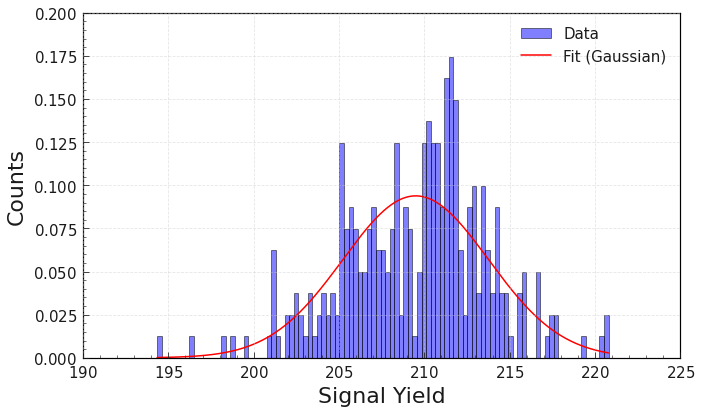

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0827                209.496  -    4.1   +    4.1       False
sigma_0.0827             4.26907  -    1.8   +    3.1       False
True


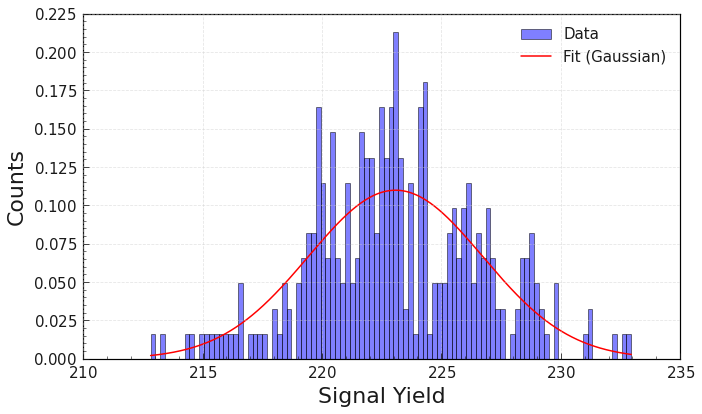

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0959                223.082  -    3.5   +    3.5       False
sigma_0.0959             3.65083  -    1.6   +    2.7       False
True


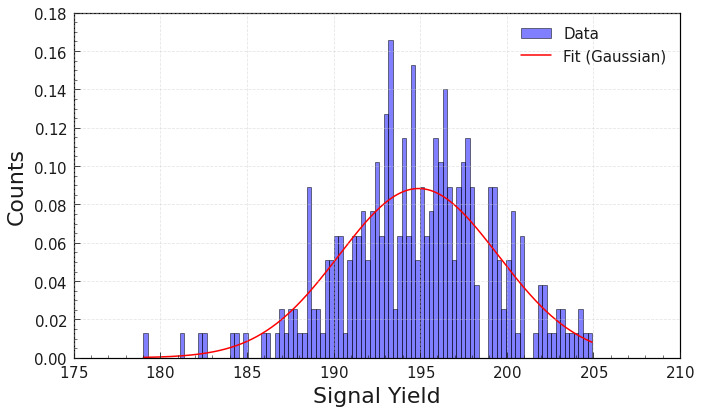

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.5464                 194.91  -    4.5   +    4.5       False
sigma_0.5464             4.58563  -      2   +    3.5       False
True


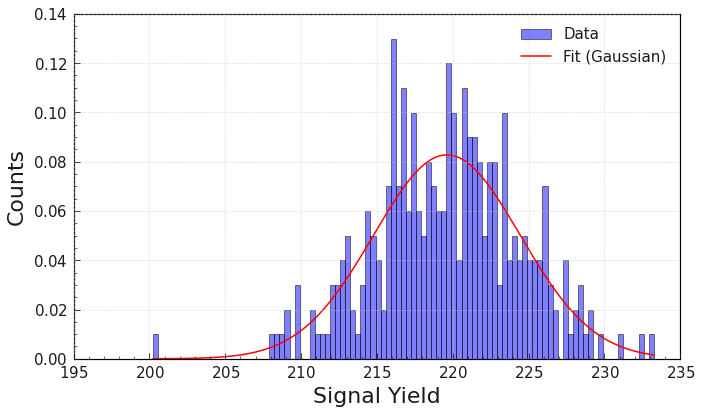

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name           value  (rounded)               errors    at limit
-----------  ------------------  -------------------  ----------
mu_0.421                219.614  -      5   +      5       False
sigma_0.421             4.83375  -    2.2   +    3.7       False
True


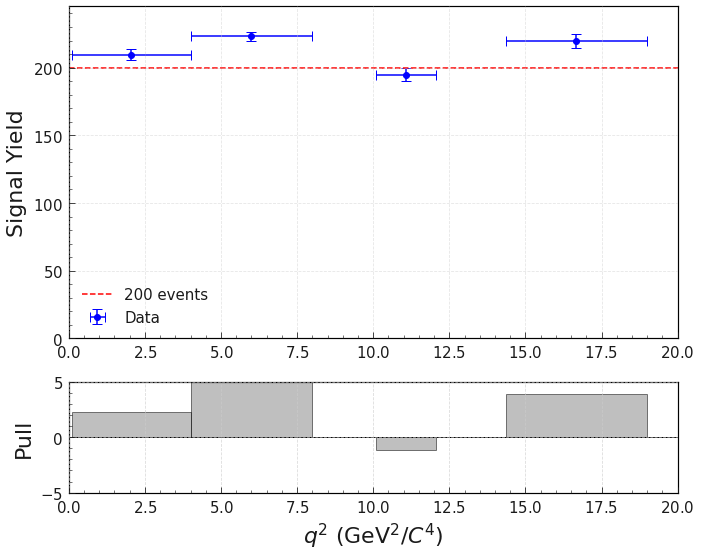

In [5]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_200.csv", "Bppip_q2reg1_decay_ee_200", q2reg="(0.1, 4.0)", event_label="200")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_200.csv", "Bppip_q2reg2_decay_ee_200", q2reg="(4.0, 8.0)", event_label="200")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_200.csv", "Bppip_q2reg3_decay_ee_200", q2reg="(10.087, 12.052)", event_label="200")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_200.csv", "Bppip_q2reg4_decay_ee_200", q2reg="(14.349, 18.993)", event_label="200")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_200 = pd.DataFrame(events_and_errors_200, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_200 .to_csv('Bppip_q2reg_ee_events_and_errors_200.csv', index=False)


# Call the function with the correct parameters
plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_200.csv',
    plot_title='Bppip_q2reg_ee_200',
    no_events=200
)

## 150 events

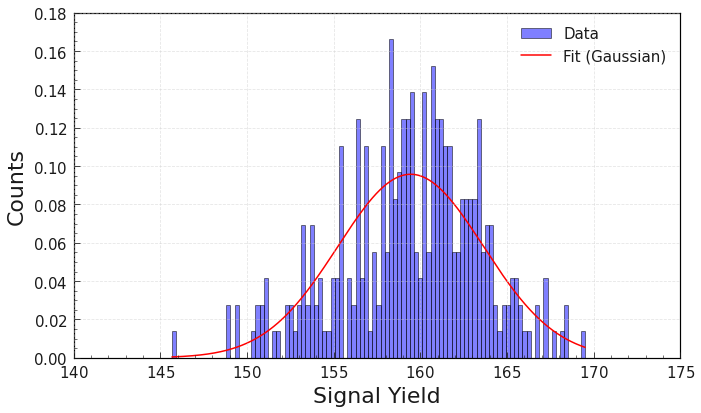

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.8308                159.449  -    7.1   +    3.7       False
sigma_0.8308             4.20448  -    1.7   +    2.8       False
True


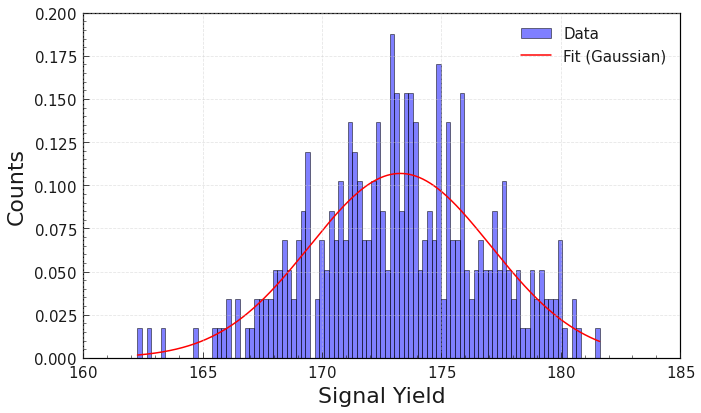

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0514                173.279  -    3.4   +    3.4       False
sigma_0.0514              3.7934  -    1.6   +    2.8       False
True


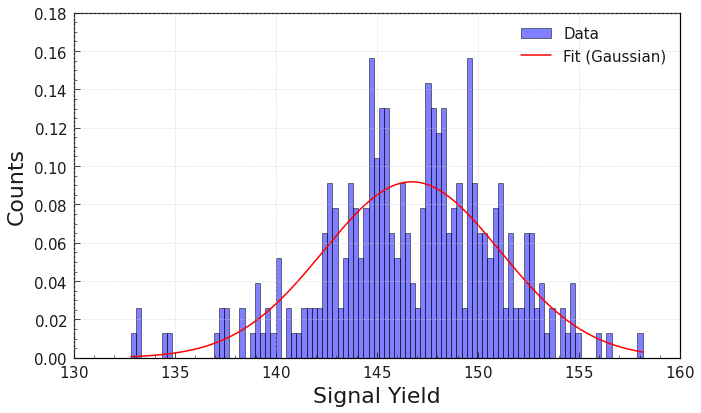

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.9683                146.729  -    6.2   +     22       False
sigma_0.9683             4.36926  -    1.7   +     23       False
True


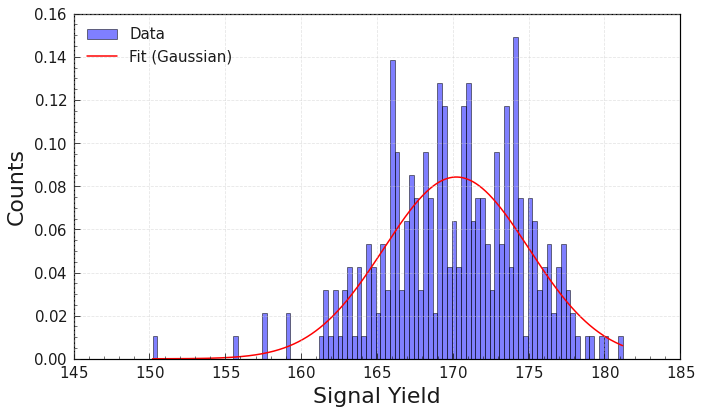

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0406                170.237  -    6.1   +    4.7       False
sigma_0.0406              4.7862  -    2.1   +    3.6       False
True


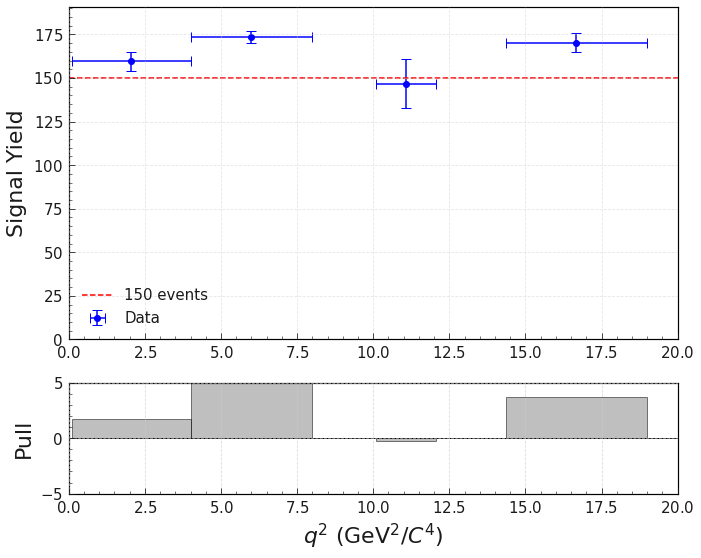

In [6]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_150.csv", "Bppip_q2reg1_decay_ee_150", q2reg="(0.1, 4.0)", event_label="150")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_150.csv", "Bppip_q2reg2_decay_ee_150", q2reg="(4.0, 8.0)", event_label="150")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_150.csv", "Bppip_q2reg3_decay_ee_150", q2reg="(10.087, 12.052)", event_label="150")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_150.csv", "Bppip_q2reg4_decay_ee_150", q2reg="(14.349, 18.993)", event_label="150")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_150 = pd.DataFrame(events_and_errors_150, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_150 .to_csv('Bppip_q2reg_ee_events_and_errors_150.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_150.csv',
    plot_title='Bppip_q2reg_ee_150',
    no_events=150
)

##  100 events

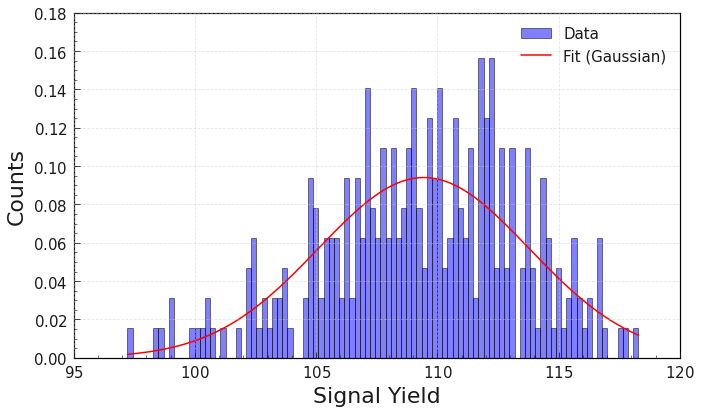

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1965                109.435  -    3.4   +    3.4       False
sigma_0.1965             4.34355  -    1.7   +    2.8       False
True


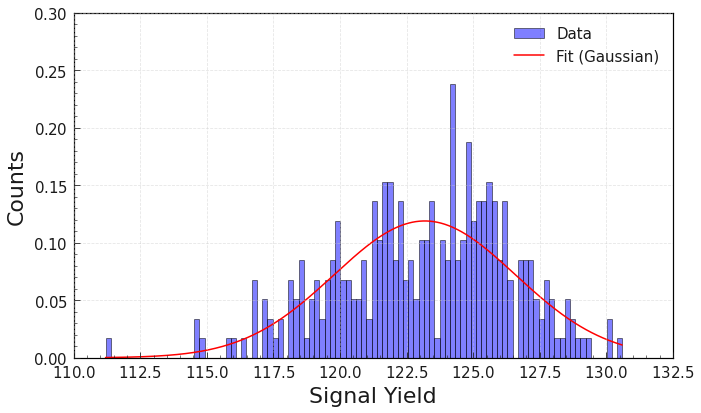

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.4366                123.181  -      3   +     18       False
sigma_0.4366             3.40463  -    1.3   +     12       False
True


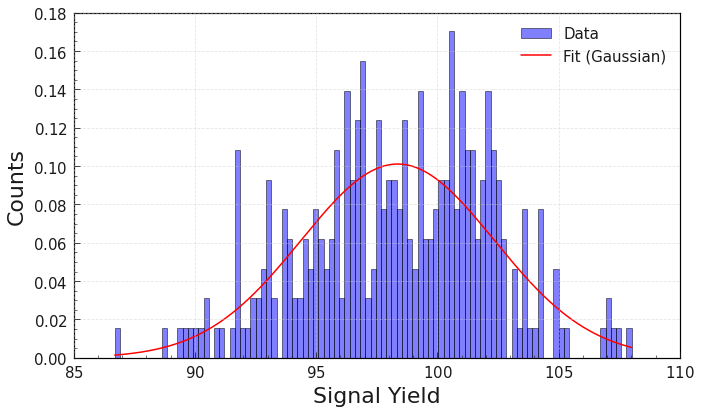

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.8592                98.3611  -    4.1   +    8.5       False
sigma_0.8592             3.98495  -    1.4   +     11       False
True


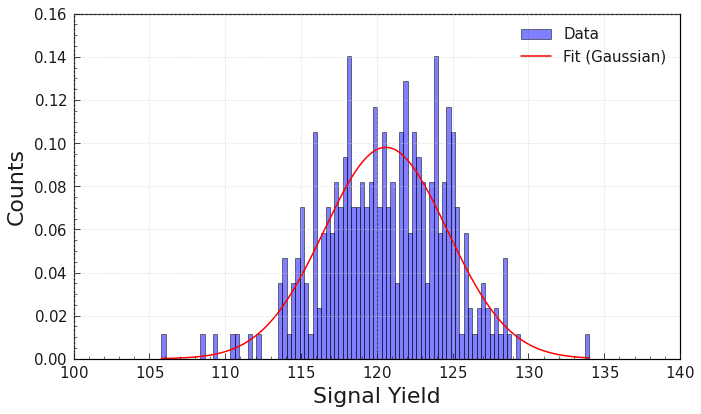

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0094                120.591  -    4.4   +    4.9       False
sigma_0.0094             4.07212  -    1.6   +    6.6       False
True


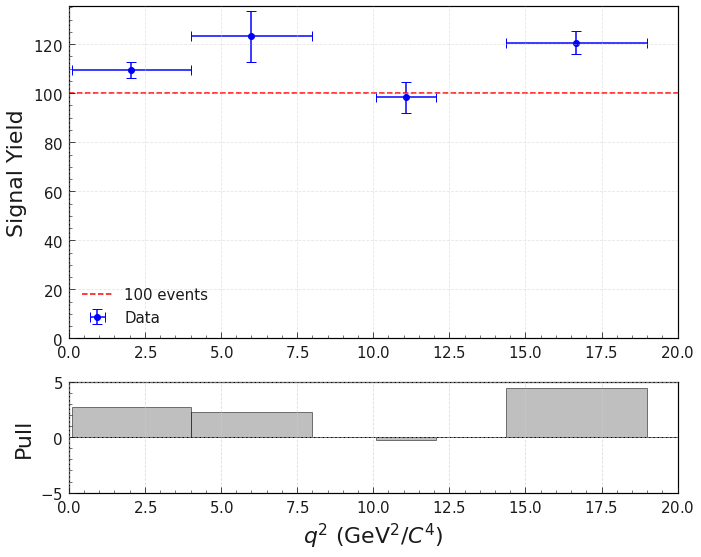

In [7]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_100.csv", "Bppip_q2reg1_decay_ee_100", q2reg="(0.1, 4.0)", event_label="100")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_100.csv", "Bppip_q2reg2_decay_ee_100", q2reg="(4.0, 8.0)", event_label="100")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_100.csv", "Bppip_q2reg3_decay_ee_100", q2reg="(10.087, 12.052)", event_label="100")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_100.csv", "Bppip_q2reg4_decay_ee_100", q2reg="(14.349, 18.993)", event_label="100")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_100 = pd.DataFrame(events_and_errors_100, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_100 .to_csv('Bppip_q2reg_ee_events_and_errors_100.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_100.csv',
    plot_title='Bppip_q2reg_ee_100',
    no_events=100
)

## 75 events

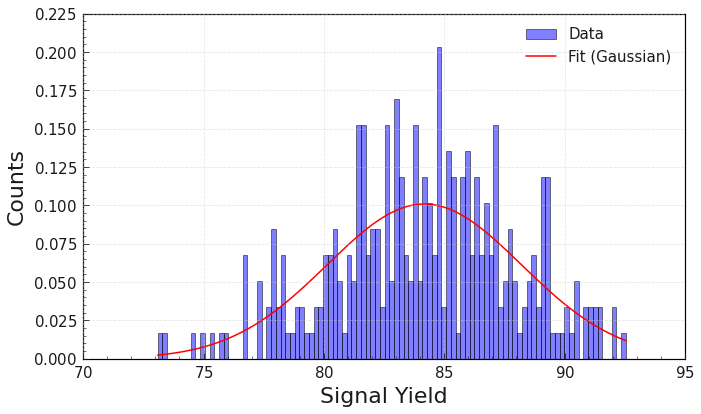

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2909                84.1729  -      4   +    2.9       False
sigma_0.2909             4.04344  -    1.5   +    2.4       False
True


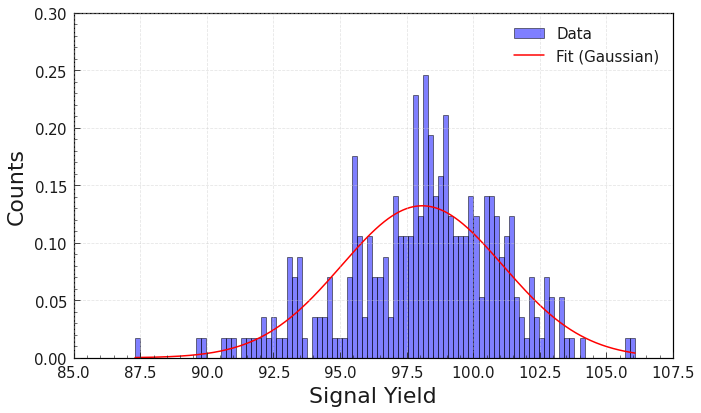

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.6761                98.0853  -    2.3   +    3.3       False
sigma_0.6761              3.0321  -      1   +    3.8       False
True


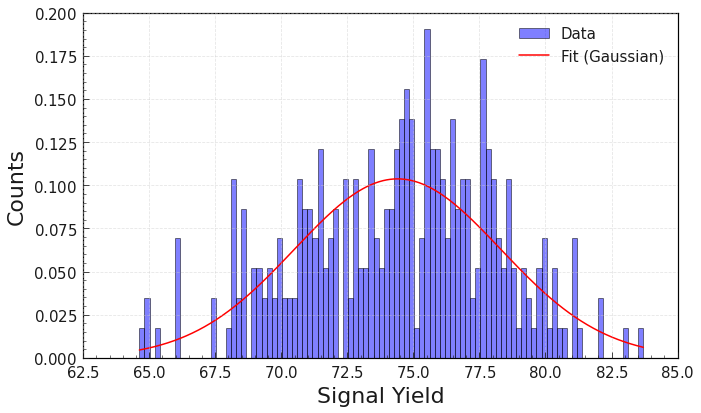

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.6297                74.4019  -    4.7   +      6       False
sigma_0.6297             3.90495  -    1.4   +     11       False
True


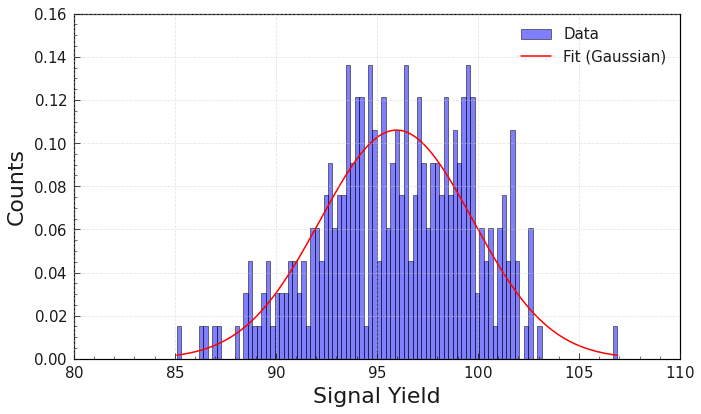

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.4484                95.9736  -    5.1   +    5.1       False
sigma_0.4484             3.77726  -    1.4   +      9       False
True


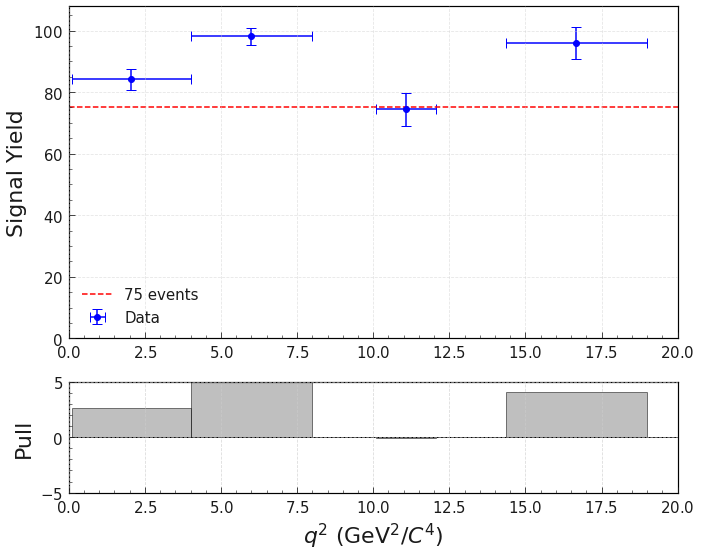

In [8]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_75.csv", "Bppip_q2reg1_decay_ee_75", q2reg="(0.1, 4.0)", event_label="75")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_75.csv", "Bppip_q2reg2_decay_ee_75", q2reg="(4.0, 8.0)", event_label="75")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_75.csv", "Bppip_q2reg3_decay_ee_75", q2reg="(10.087, 12.052)", event_label="75")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_75.csv", "Bppip_q2reg4_decay_ee_75", q2reg="(14.349, 18.993)", event_label="75")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_75 = pd.DataFrame(events_and_errors_75, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_75 .to_csv('Bppip_q2reg_ee_events_and_errors_75.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_75.csv',
    plot_title='Bppip_q2reg_ee_75',
    no_events=75
)

## 50 events

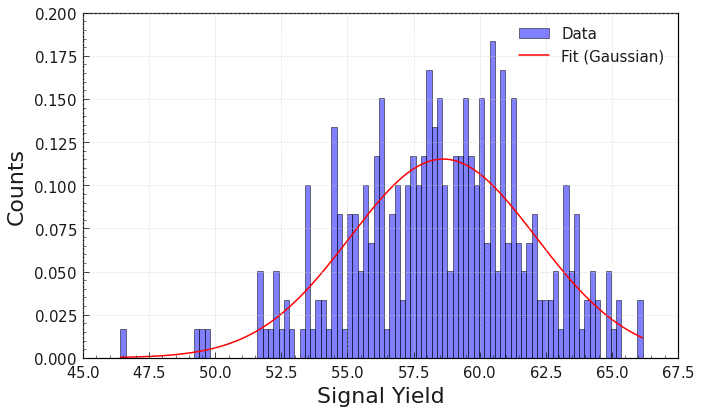

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0745                58.6193  -    2.2   +    4.3       False
sigma_0.0745             3.52104  -    1.1   +    4.1       False
True


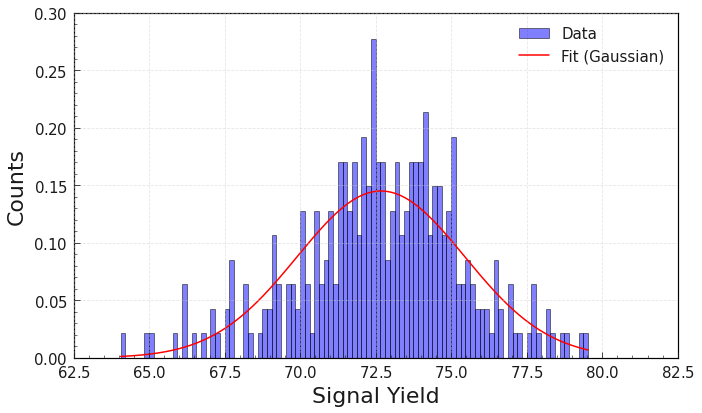

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name           value  (rounded)               errors    at limit
-----------  ------------------  -------------------  ----------
mu_0.073                72.6748  -    1.9   +    2.6       False
sigma_0.073             2.77261  -   0.89   +    3.2       False
True


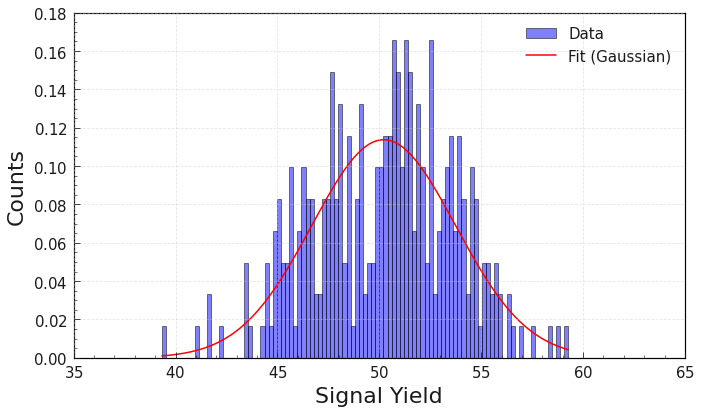

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2324                50.2145  -    2.2   +    2.6       False
sigma_0.2324             3.52927  -    1.1   +    3.1       False
True


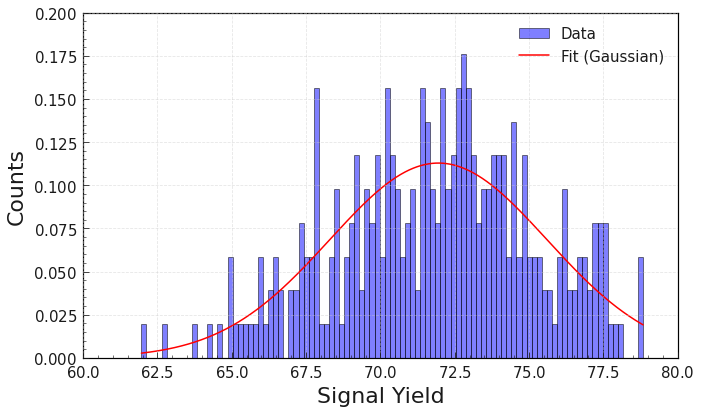

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.3501                71.9509  -    2.8   +    2.8       False
sigma_0.3501             3.65474  -    1.4   +    2.4       False
True


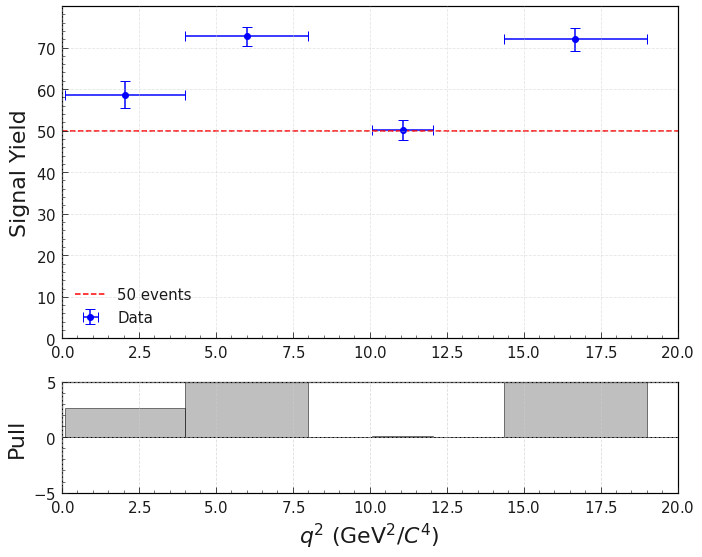

In [9]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_50.csv", "Bppip_q2reg1_decay_ee_50", q2reg="(0.1, 4.0)", event_label="50")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_50.csv", "Bppip_q2reg2_decay_ee_50", q2reg="(4.0, 8.0)", event_label="50")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_50.csv", "Bppip_q2reg3_decay_ee_50", q2reg="(10.087, 12.052)", event_label="50")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_50.csv", "Bppip_q2reg4_decay_ee_50", q2reg="(14.349, 18.993)", event_label="50")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_50 = pd.DataFrame(events_and_errors_50, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_50 .to_csv('Bppip_q2reg_ee_events_and_errors_50.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_50.csv',
    plot_title='Bppip_q2reg_ee_50',
    no_events=50
)

## 25 events

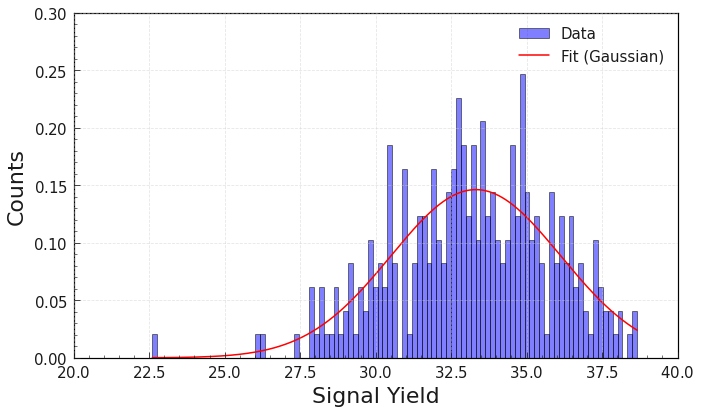

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.6054                33.3185  -    1.4   +    2.7       False
sigma_0.6054             2.80906  -   0.82   +    2.3       False
True


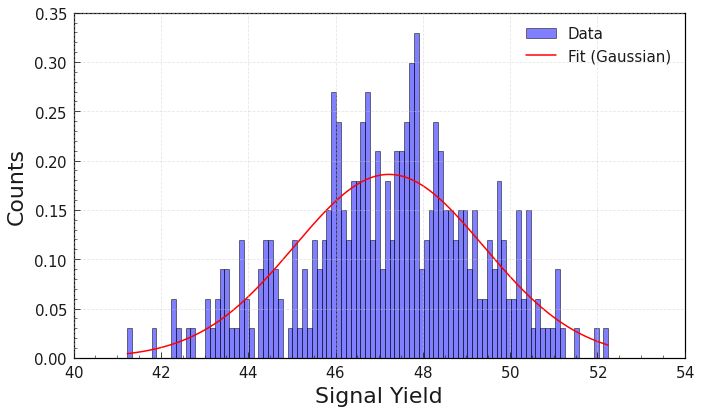

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.2838                47.2239  -    1.3   +    1.7       False
sigma_0.2838             2.17366  -   0.64   +    2.1       False
True


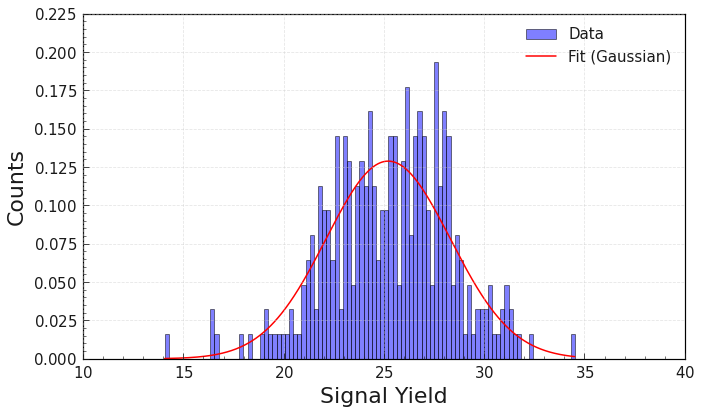

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.4188                25.2122  -    1.4   +    1.5       False
sigma_0.4188             3.10008  -   0.78   +    1.5       False
True


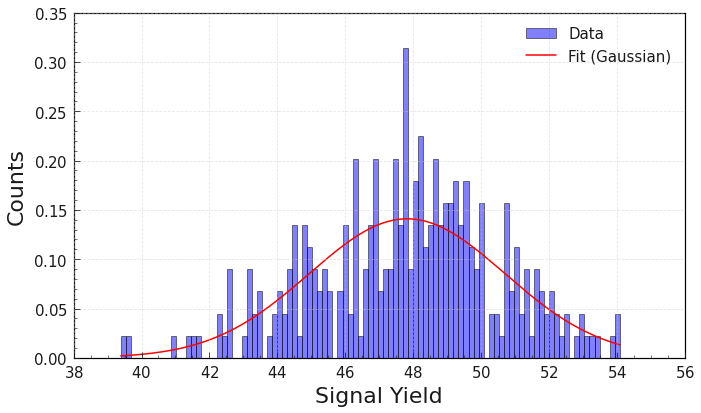

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0462                47.8219  -    2.1   +    4.5       False
sigma_0.0462             2.87754  -   0.97   +      5       False
True


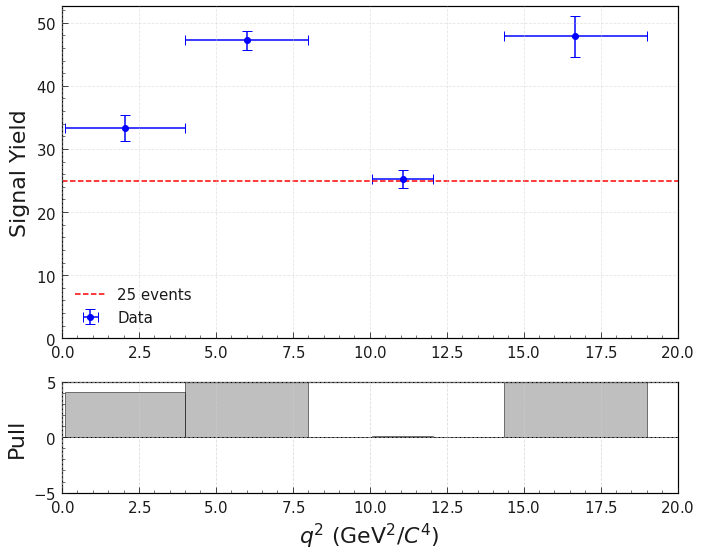

In [10]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_25.csv", "Bppip_q2reg1_decay_ee_25", q2reg="(0.1, 4.0)", event_label="25")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_25.csv", "Bppip_q2reg2_decay_ee_25", q2reg="(4.0, 8.0)", event_label="25")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_25.csv", "Bppip_q2reg3_decay_ee_25", q2reg="(10.087, 12.052)", event_label="25")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_25.csv", "Bppip_q2reg4_decay_ee_25", q2reg="(14.349, 18.993)", event_label="25")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_25 = pd.DataFrame(events_and_errors_25, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_25 .to_csv('Bppip_q2reg_ee_events_and_errors_25.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_25.csv',
    plot_title='Bppip_q2reg_ee_25',
    no_events=25
)

## 10 events

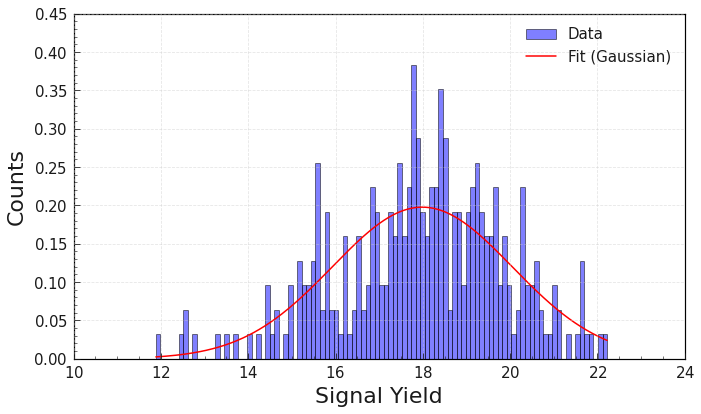

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.6444                 17.988  -   0.88   +    1.2       False
sigma_0.6444             2.06189  -   0.52   +    1.3       False
True


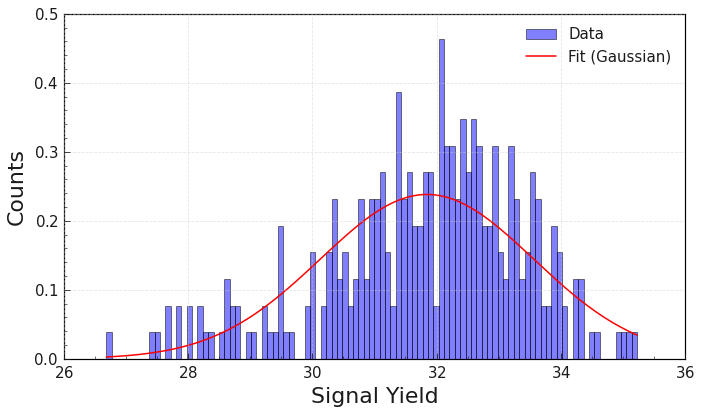

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.3337                31.8467  -    0.8   +    1.4       False
sigma_0.3337             1.71994  -   0.48   +    1.4       False
True


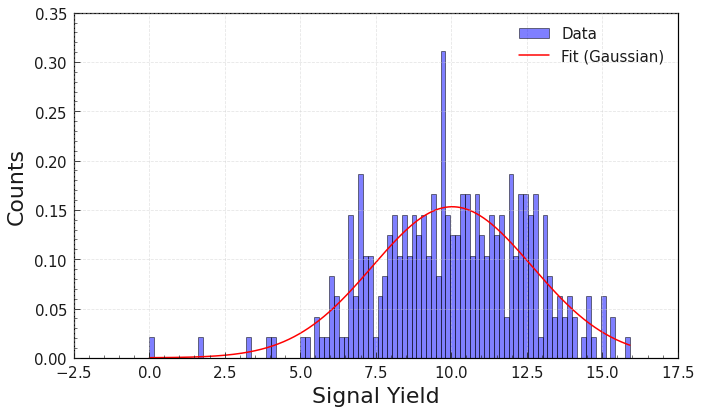

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.7088                10.0338  -   0.98   +    1.2       False
sigma_0.7088             2.63835  -   0.59   +    1.1       False
True


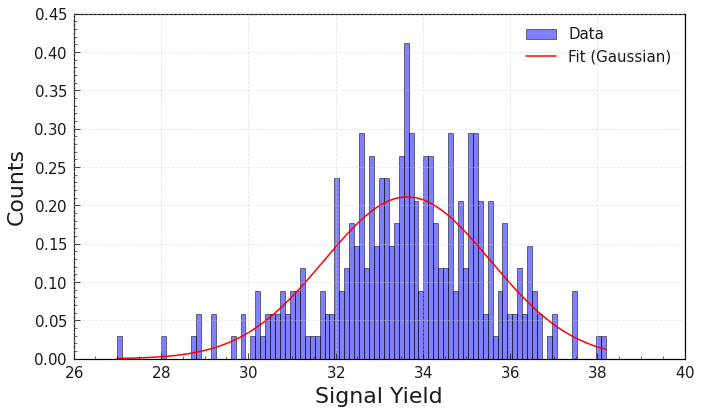

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.7491                33.6425  -    1.1   +    1.6       False
sigma_0.7491             1.90641  -   0.57   +    1.6       False
True


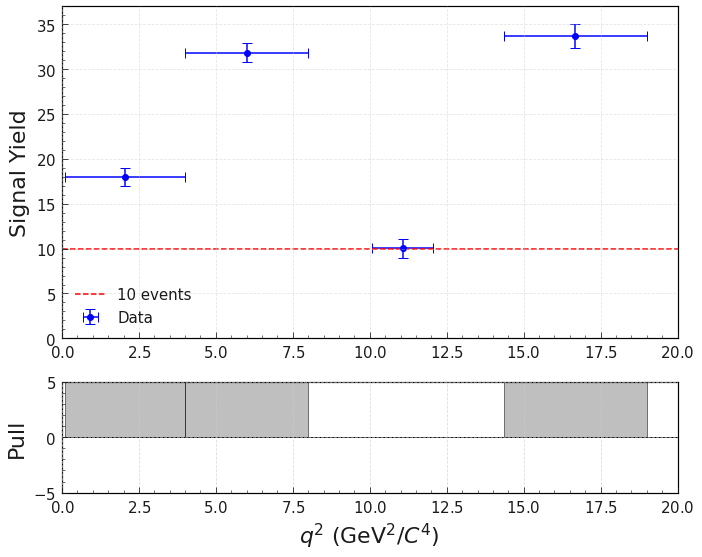

In [11]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_10.csv", "Bppip_q2reg1_decay_ee_10", q2reg="(0.1, 4.0)", event_label="10")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_10.csv", "Bppip_q2reg2_decay_ee_10", q2reg="(4.0, 8.0)", event_label="10")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_10.csv", "Bppip_q2reg3_decay_ee_10", q2reg="(10.087, 12.052)", event_label="10")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_10.csv", "Bppip_q2reg4_decay_ee_10", q2reg="(14.349, 18.993)", event_label="10")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_10 = pd.DataFrame(events_and_errors_10, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_10 .to_csv('Bppip_q2reg_ee_events_and_errors_10.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_10.csv',
    plot_title='Bppip_q2reg_ee_10',
    no_events=10
)

## 5 events

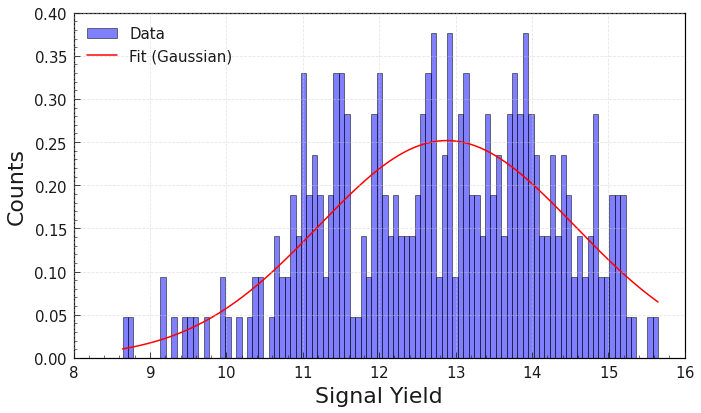

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.0324                12.8847  -    0.7   +    1.4       False
sigma_0.0324              1.6772  -   0.45   +    1.5       False
True


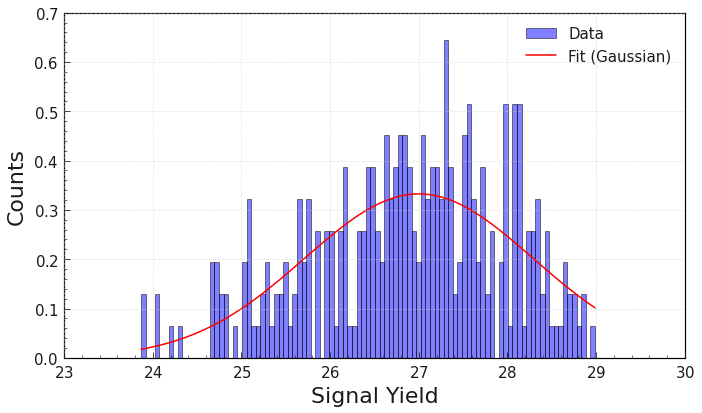

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.6464                27.0008  -   0.64   +    2.5       False
sigma_0.6464             1.28908  -   0.39   +    2.3       False
True


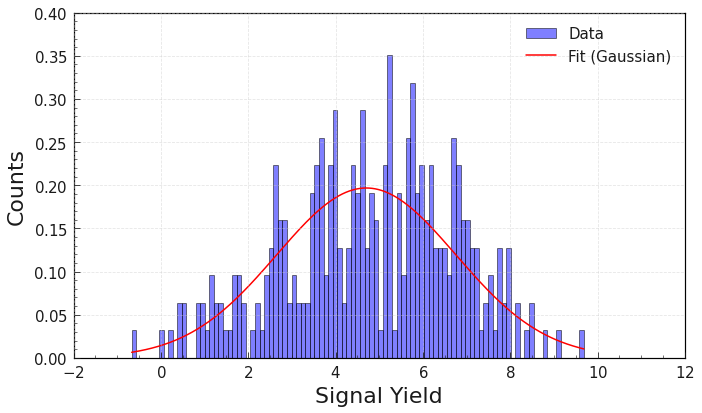

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1491                4.70216  -   0.71   +   0.75       False
sigma_0.1491             2.05152  -   0.42   +   0.86       False
True


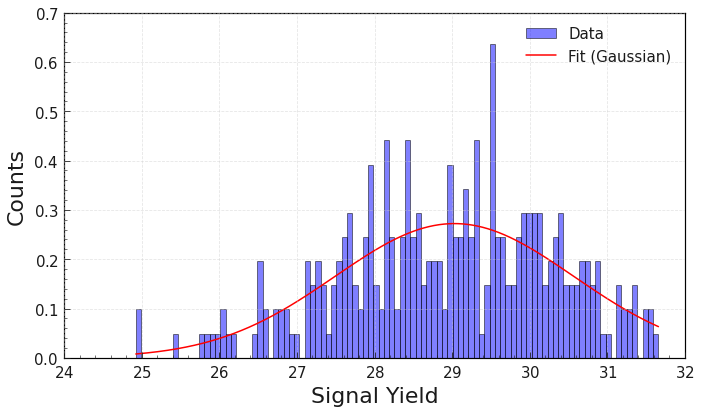

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.6674                29.0292  -   0.94   +    6.3       False
sigma_0.6674              1.5386  -   0.52   +    4.5       False
True


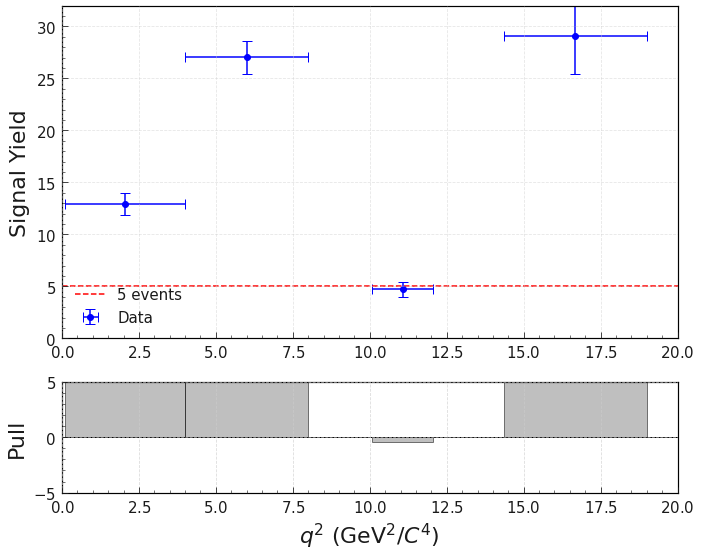

In [12]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_5.csv", "Bppip_q2reg1_decay_ee_5", q2reg="(0.1, 4.0)", event_label="5")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_5.csv", "Bppip_q2reg2_decay_ee_5", q2reg="(4.0, 8.0)", event_label="5")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_5.csv", "Bppip_q2reg3_decay_ee_5", q2reg="(10.087, 12.052)", event_label="5")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_5.csv", "Bppip_q2reg4_decay_ee_5", q2reg="(14.349, 18.993)", event_label="5")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_5 = pd.DataFrame(events_and_errors_5, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_5 .to_csv('Bppip_q2reg_ee_events_and_errors_5.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_5.csv',
    plot_title='Bppip_q2reg_ee_5',
    no_events=5
)

## 2 events

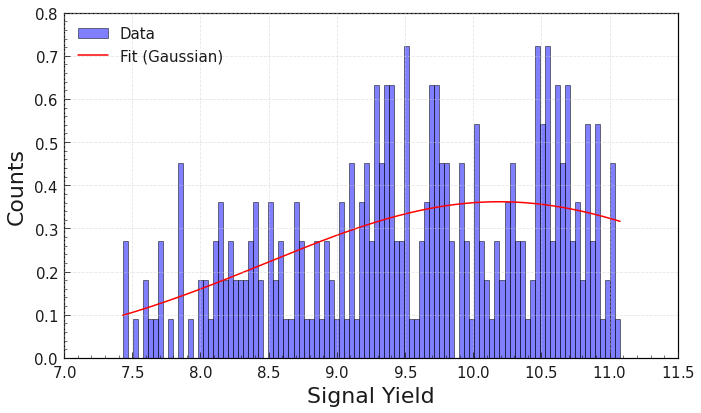

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.9778                  10.19  -    1.7   +    1.7       False
sigma_0.9778             1.71093  -   0.77   +    1.5       False
True


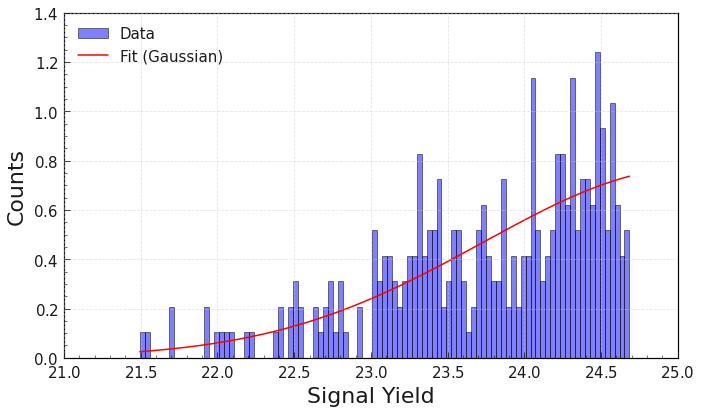

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.1789                25.1091  -    1.3   +    2.8       False
sigma_0.1789              1.3777  -   0.68   +    1.1       False
True


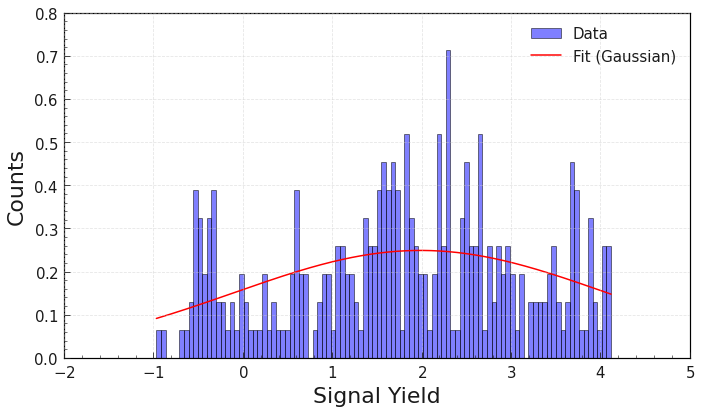

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.4074                1.98716  -    1.1   +    1.1       False
sigma_0.4074             2.08554  -   0.75   +    1.4       False
True


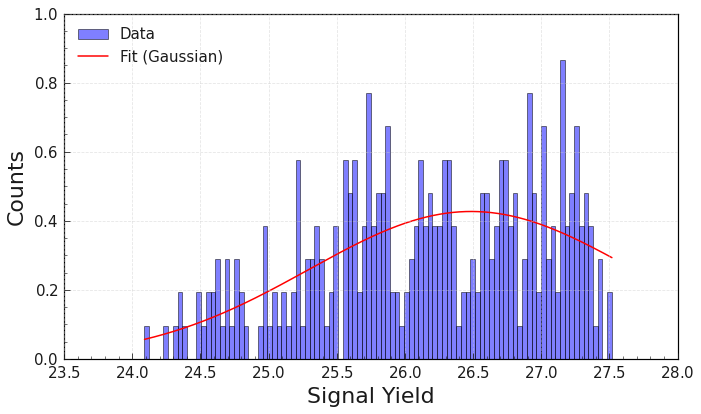

/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name            value  (rounded)               errors    at limit
------------  ------------------  -------------------  ----------
mu_0.7936                 26.486  -    1.2   +    1.2       False
sigma_0.7936              1.1906  -   0.52   +    1.1       False
True


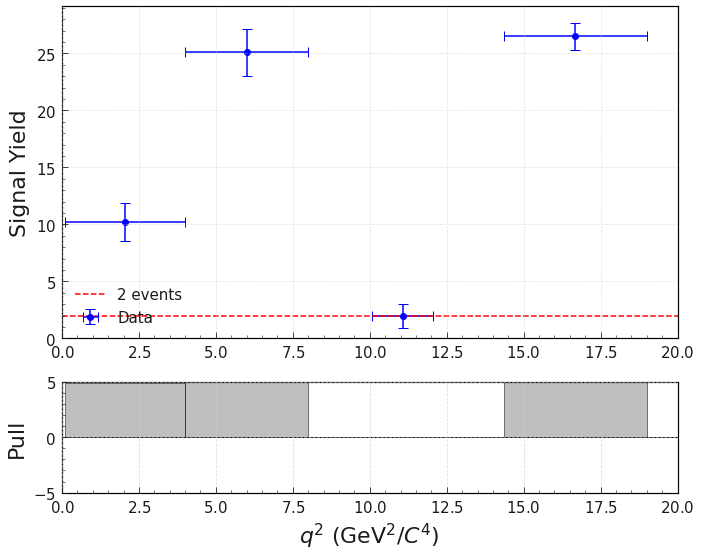

In [13]:
fit_and_plot_gaussian("Bppip_q2reg1_decay_ee_signal_yields_and_errors_2.csv", "Bppip_q2reg1_decay_ee_2", q2reg="(0.1, 4.0)", event_label="2")
fit_and_plot_gaussian("Bppip_q2reg2_decay_ee_signal_yields_and_errors_2.csv", "Bppip_q2reg2_decay_ee_2", q2reg="(4.0, 8.0)", event_label="2")
fit_and_plot_gaussian("Bppip_q2reg3_decay_ee_signal_yields_and_errors_2.csv", "Bppip_q2reg3_decay_ee_2", q2reg="(10.087, 12.052)", event_label="2")
fit_and_plot_gaussian("Bppip_q2reg4_decay_ee_signal_yields_and_errors_2.csv", "Bppip_q2reg4_decay_ee_2", q2reg="(14.349, 18.993)", event_label="2")


# Convert the list to a DataFrame with two columns: 'Signal_Yield' and 'Signal_Yield_Error'
events_df_2 = pd.DataFrame(events_and_errors_2, columns=['q2reg','MC_signal','mu', 'mu_error','sigma','sigma_error'])

# Save the DataFrame to a CSV file
events_df_2 .to_csv('Bppip_q2reg_ee_events_and_errors_2.csv', index=False)


plot_error_bar_with_pull_from_csv(
    file_path='Bppip_q2reg_ee_events_and_errors_2.csv',
    plot_title='Bppip_q2reg_ee_2',
    no_events=2
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


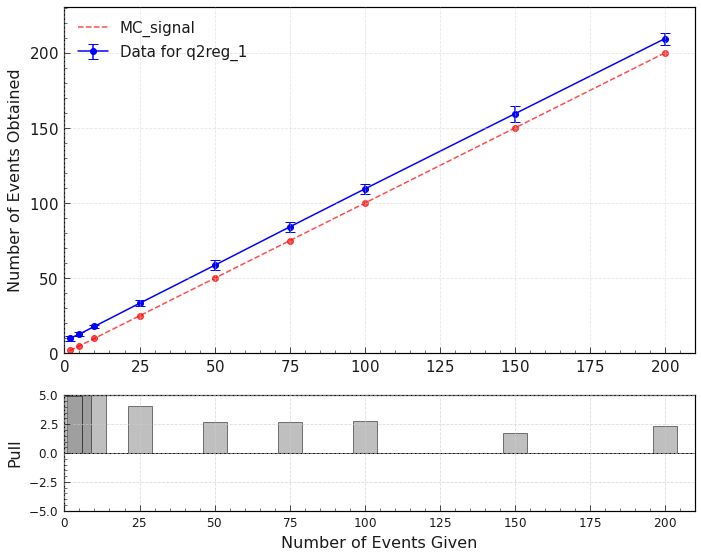

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


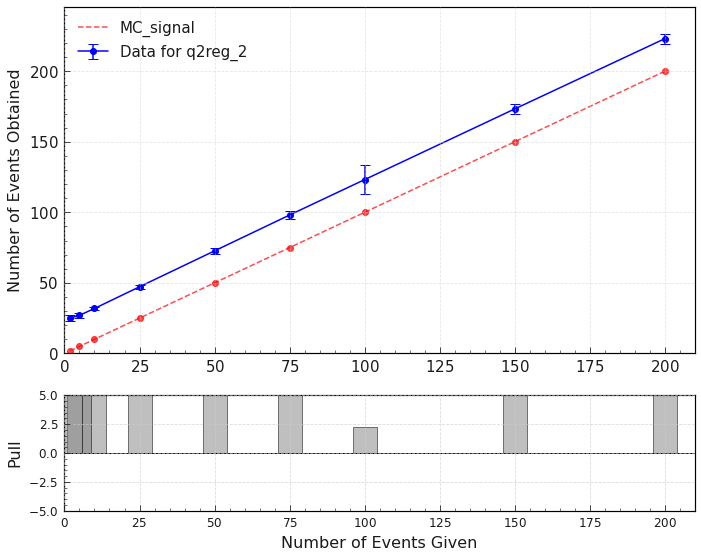

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


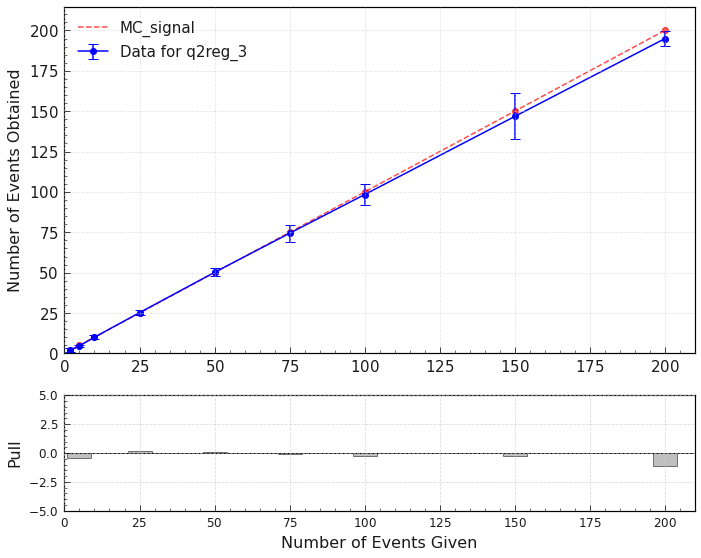

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


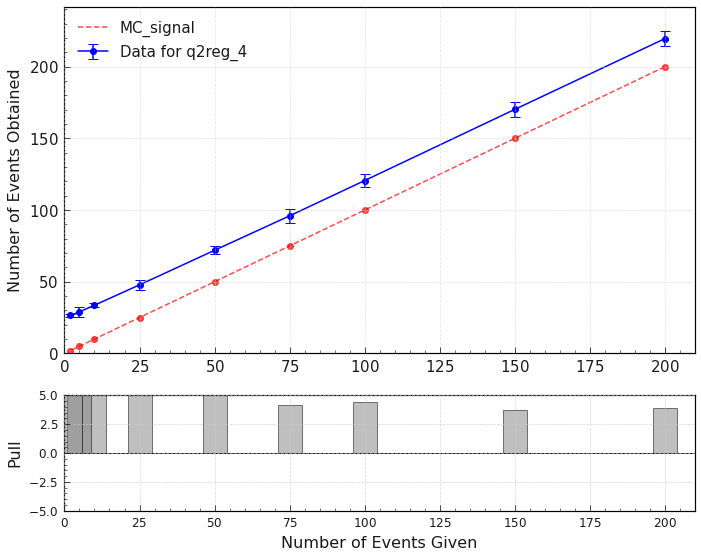

In [14]:
# Define the number of events used in the experiments
event_levels = [200, 150, 100, 75, 50, 25, 10, 5, 2]

# Prepare data structure for plotting
q2_ranges = ["(0.1, 4.0)", "(4.0, 8.0)", "(10.087, 12.052)", "(14.349, 18.993)"]
q2_labels = ["q2reg_1", "q2reg_2", "q2reg_3", "q2reg_4"]

event_data = {
    "(0.1, 4.0)": [],
    "(4.0, 8.0)": [],
    "(10.087, 12.052)": [],
    "(14.349, 18.993)": []
}

# Populate event_data with tuples of (event_level, mu, mu_error) for each q2 region
for data, label in zip([events_and_errors_200, events_and_errors_150, events_and_errors_100, events_and_errors_75,
                        events_and_errors_50, events_and_errors_25, events_and_errors_10, events_and_errors_5, events_and_errors_2],
                       event_levels):
    for entry in data:
        q2reg, MC_signal, mu, mu_error, sigma, sigma_error = entry
        event_data[q2reg].append((label, MC_signal, mu, mu_error))

# Plotting
for q2reg, q2_label in zip(q2_ranges, q2_labels):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Extract data for the current q2 region
    current_data = event_data[q2reg]
    
    # Separate event levels, mu values, and errors
    event_levels, MC_signal, mu_values, mu_errors = zip(*current_data)
    
    # Plot with error bars on the main plot (ax1)
    ax1.errorbar(event_levels, mu_values, yerr=mu_errors, fmt='o-', capsize=5, label=f'Data for {q2_label}', color='blue')
    
    # Plot the y=x line (ideal case where input equals output)
    ax1.plot(MC_signal, MC_signal, 'r--', label='MC_signal', alpha=0.7)
    ax1.scatter(MC_signal, MC_signal, color='red', alpha=0.7)
    
    # Labeling the main plot
    ax1.set_ylabel("Number of Events Obtained", fontsize=16)
    #ax1.set_title(f"Comparison of Input vs. Output Events for {q2_label}_Bppip_ee", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend()
    
    # Set x and y axis limits for ax1
    ax1.set_xlim(0, max(event_levels) + 10)
    ax1.set_ylim(0, max(mu_values) + 0.1 * max(mu_values))
    
    # Calculate the pull for each point
    pulls = [(mu - mc) / error if error != 0 else 0 for mc, mu, error in zip(MC_signal, mu_values, mu_errors)]
    
    # Plot the pull values on the bottom plot (ax2) as bars
    ax2.bar(event_levels, pulls, width=8, align='center', alpha=0.5, color='gray', edgecolor='black')

    # Horizontal line at y=0 for reference
    ax2.axhline(0, color='black', linewidth=1)
    
    # Labeling the pull plot
    ax2.set_xlabel("Number of Events Given", fontsize=16)
    ax2.set_ylabel("Pull", fontsize=16)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Set x-axis limits for ax2 to match ax1
    ax2.set_xlim(ax1.get_xlim())
    
    # Set y-axis limits for pull plot
    ax2.set_ylim(-5, 5)  # Adjust limits as needed to capture most of the pull range

    # Align the x-axes of both plots
    ax1.get_shared_x_axes().join(ax1, ax2)

    # Adjust layout with constrained_layout to ensure better alignment
    fig.tight_layout(h_pad=1.0)
    plt.savefig(f'Comparison of Input vs. Output Events for {q2_label}_Bppip_ee.pdf', format='pdf')
    plt.show()


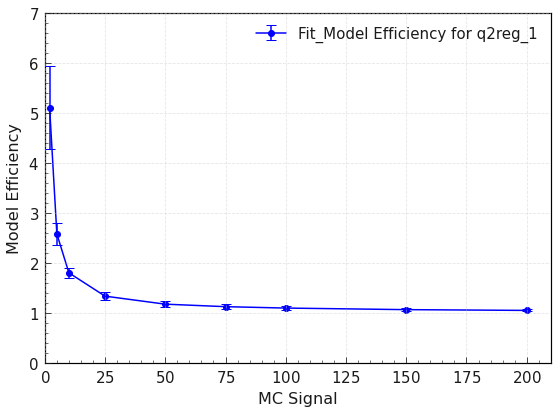

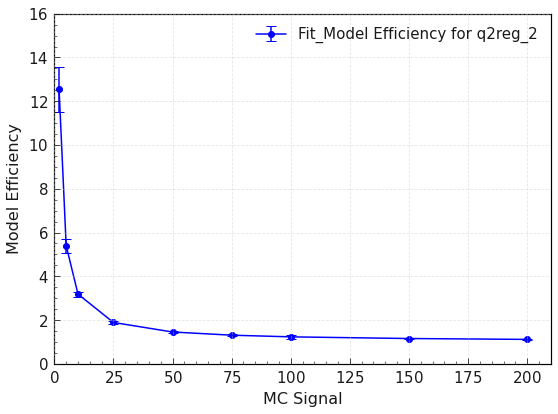

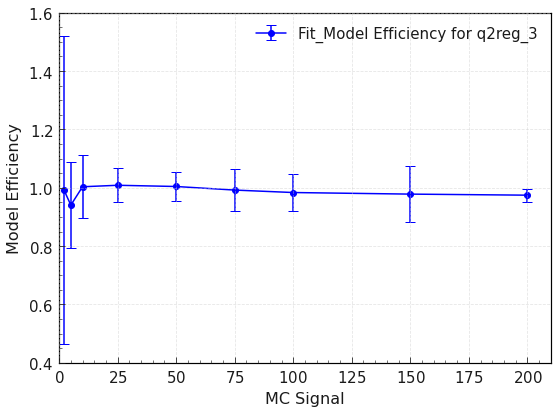

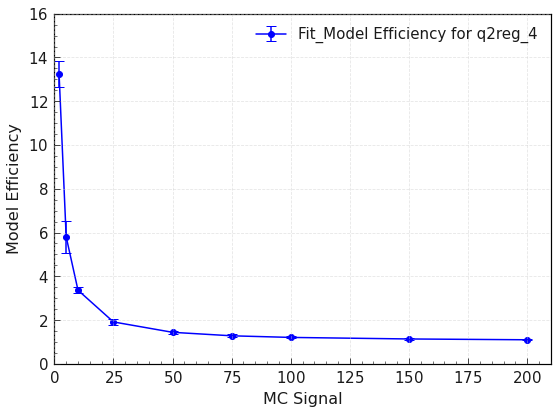

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of events used in the experiments
event_levels = [200, 150, 100, 75, 50, 25, 10, 5, 2]

# Prepare data structure for plotting
q2_ranges = ["(0.1, 4.0)", "(4.0, 8.0)", "(10.087, 12.052)", "(14.349, 18.993)"]
q2_labels = ["q2reg_1", "q2reg_2", "q2reg_3", "q2reg_4"]

event_data = {
    "(0.1, 4.0)": [],
    "(4.0, 8.0)": [],
    "(10.087, 12.052)": [],
    "(14.349, 18.993)": []
}

# Populate event_data with tuples of (event_level, MC_signal, mu, mu_error) for each q2 region
for data, label in zip([events_and_errors_200, events_and_errors_150, events_and_errors_100, events_and_errors_75,
                        events_and_errors_50, events_and_errors_25, events_and_errors_10, events_and_errors_5, events_and_errors_2],
                       event_levels):
    for entry in data:
        q2reg, MC_signal, mu, mu_error, sigma, sigma_error = entry
        event_data[q2reg].append((label, MC_signal, mu, mu_error))

# Plotting Fit_Model efficiency vs MC signal
for q2reg, q2_label in zip(q2_ranges, q2_labels):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Extract data for the current q2 region
    current_data = event_data[q2reg]
    
    # Separate event levels, MC_signal, mu values, and errors
    event_levels, MC_signal, mu_values, mu_errors = zip(*current_data)
    
    # Convert to numpy arrays for calculations
    MC_signal = np.array(MC_signal)
    mu_values = np.array(mu_values)
    mu_errors = np.array(mu_errors)

    # Calculate Fit_Model efficiency
    Fit_Model_efficiency = mu_values / MC_signal
    
    # Calculate the uncertainty in Fit_Model efficiency
    eff_errors = mu_errors / MC_signal
    
    # Plot Fit_Model efficiency vs MC signal with error bars
    ax.errorbar(MC_signal, Fit_Model_efficiency, yerr=eff_errors, fmt='o-', label=f'Fit_Model Efficiency for {q2_label}', color='blue', capsize=5)
    
    # Labeling the plot
    ax.set_xlabel("MC Signal", fontsize=16)
    ax.set_ylabel("Model Efficiency", fontsize=16)
    #ax.set_title(f"Fit_Model Efficiency vs. MC Signal for {q2_label}_Bppip_ee", fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    
    # Set x and y axis limits
    #ax.yscale("log")
    ax.set_xlim(0, max(MC_signal) + 10)
    #ax.set_ylim(0, 1.1)  # Efficiency is generally between 0 and 1
    
    # Save and show the plot
    plt.tight_layout()
    plt.savefig(f'Fit_Model Efficiency vs MC Signal for {q2_label}_Bppip_ee.pdf', format='pdf')
    plt.show()
